# Web Scraping the Top 250 Movies on IMDB

description of project from proposal.

In [1]:
from bs4 import BeautifulSoup
import requests
import re
import numpy as np
import pandas as pd


### Part I: Web Scraping Tool
Creating a function that web scrapes from multiple links, parses the HTML, and stores in a pandas DataFrame.

In [2]:
def web_scrape_page(url):
    resp = requests.get(url)
    
    #All info from webpage scraped
    soup = BeautifulSoup(resp.text,'html.parser')
    
    #Scraping header: movie title and year
    scraped_titles = soup.find_all('h3',{"class":"lister-item-header"})
    
    #Scraping for movie title
    movies = []
    for x in scraped_titles:
        for y in x.find_all('a'):
            movies.append(y.text)
    
    #Scraping for movie year
    years = []
    for x in scraped_titles:
        for y in x.find_all('span'):
            years.append(y.text)
    years = years[1::2]
    
    #Scraping from muted text, which is where the movie details are stored: rating, time, genres
    scraped_details = soup.find_all('p',{"class":"text-muted"})
    details = []
    for x in scraped_details:
        for y in x.find_all('span'):
            details.append(y.text)
    
    #Scraping rating
    ratings = details[0::5]
    
    #Scraping movie duration
    t = details[2::5]
    time = []
    for i in t:
        var = i.strip(" min")
        time.append(var)
    
    #scraping genre
    g = details[4::5]
    genres = []
    for i in range(len(g)):
        genres.append(g[i].strip())
    
    #Scraping from ratings bar
    scraped_ratings_bar = soup.find_all('div',{"class":"ratings-bar"})
    s = []
    for x in scraped_ratings_bar:
        for y in x.find_all('div',{"class":"inline-block ratings-imdb-rating"}):
            s.append(y.text)
    stars = []
    for i in s:
        stars.append(i.strip("\n"))
        
    #Scraping directors 
    directors = []
    for element in soup.find_all(text=re.compile("Director")):
        a = element.nextSibling
        directors.append(a.text)
    
    #Scraping actors
    actors = []
    for element in soup.find_all(text=re.compile("Stars")):
        a = element.nextSibling
        actors.append(a.text)
        
    #Scraping from num votes, which is where votes and gross $ are stored
    scraped_nums = soup.find_all('p',{"class":"sort-num_votes-visible"})
    nums = []
    for x in scraped_nums:
        for y in x.find_all('span'):
            nums.append(y.text)
    nums = np.array(nums)
    m = []
    for x in scraped_ratings_bar:
        for y in x.find_all('div',{"class":"inline-block ratings-metascore"}):
            m.append(y.text)
    metascore = []

    for i in range(len(m)):
        metascore.append(int(((((((m[i].strip("\n")).strip(" ")).strip("\n")).strip("Metascore")).strip(" ")).strip("\n")).strip(" ")))
    searchval = "Votes:"
    ind = np.where(nums == searchval)[0]+1
    votes = nums[ind]
    searchval = "Gross:"
    ind = np.where(nums == searchval)[0]+1
    gr = nums[ind]
    gross = []

    for i in range(len(gr)):
        a = gr[i].strip("$")
        gross.append(a.strip("M"))
        
    #Creating DataFrame
    df = pd.DataFrame([movies,years,ratings,time,genres,stars,metascore,votes,gross,directors,actors]).transpose()
    df.columns = ['Movie', 'Year', 'Rating', 'Duration (min)', 'Genres','Stars','Metascore','Votes','Gross ($M)', 'Director','Lead']
    
    return df

The movies are spread across 5 different webpages. We use our function to scrape each page and concatenate the resulting DataFrames, reindexing the final DataFrame so each movie has it's unique identifier. 

In [3]:
pg1 = web_scrape_page("https://www.imdb.com/search/title/?groups=top_250&sort=user_rating")
pg2 = web_scrape_page("https://www.imdb.com/search/title/?groups=top_250&sort=user_rating,desc&start=51&ref_=adv_nxt")
pg3 = web_scrape_page("https://www.imdb.com/search/title/?groups=top_250&sort=user_rating,desc&start=101&ref_=adv_nxt")
pg4 = web_scrape_page("https://www.imdb.com/search/title/?groups=top_250&sort=user_rating,desc&start=151&ref_=adv_nxt")
pg5 = web_scrape_page("https://www.imdb.com/search/title/?groups=top_250&sort=user_rating,desc&start=201&ref_=adv_nxt")

frames = [pg1, pg2, pg3, pg4, pg5]
movies = pd.concat(frames)
movies = movies.reset_index(drop=True)

In [4]:
movies.head()

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead
0,The Shawshank Redemption,(1994),R,142,Drama,9.3,80,"2,165,475",28.34,Frank Darabont,Tim Robbins
1,The Godfather,(1972),R,175,"Crime, Drama",9.2,100,"1,486,705",134.97,Francis Ford Coppola,Marlon Brando
2,The Dark Knight,(2008),PG-13,152,"Action, Crime, Drama",9.0,84,"2,140,434",534.86,Christopher Nolan,Christian Bale
3,The Godfather: Part II,(1974),R,202,"Crime, Drama",9.0,90,"1,035,454",57.30,Francis Ford Coppola,Al Pacino
4,The Lord of the Rings: The Return of the King,(2003),PG-13,201,"Adventure, Drama, Fantasy",8.9,94,"1,537,459",377.85,Peter Jackson,Elijah Wood


In [5]:
movies.tail()

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead
245,"Monsters, Inc.",(2001),G,92,"Animation, Adventure, Comedy",8.0,None,"762,353",None,Pete Docter,Billy Crystal
246,Aladdin,(1992),G,90,"Animation, Adventure, Comedy",8.0,None,"339,642",None,Ron Clements,Scott Weinger
247,Castle in the Sky,(1986),PG,125,"Animation, Adventure, Drama",8.0,None,"132,071",None,Hayao Miyazaki,Anna Paquin
248,The Terminator,(1984),R,107,"Action, Sci-Fi",8.0,None,"753,897",None,James Cameron,Arnold Schwarzenegger
249,Butch Cassidy and the Sundance Kid,(1969),PG,110,"Biography, Crime, Drama",8.0,None,"191,723",None,George Roy Hill,Paul Newman


### Part II: Data Cleaning

We would like Year to be an integer so we could easily bin for different decades in our visualization. We strip away the paranthesis from the Year series and replace it in the movies DataFrame. 

In [6]:
#year cleaning
a = []
b = []


In [7]:
for i in range(len(movies['Year'])):
    a.append(movies['Year'].iloc[i].strip("("))
    b.append(a[i].strip(")"))

In [8]:
movies['Year'] = b

In [9]:
movies.head()

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead
0,The Shawshank Redemption,1994,R,142,Drama,9.3,80,"2,165,475",28.34,Frank Darabont,Tim Robbins
1,The Godfather,1972,R,175,"Crime, Drama",9.2,100,"1,486,705",134.97,Francis Ford Coppola,Marlon Brando
2,The Dark Knight,2008,PG-13,152,"Action, Crime, Drama",9.0,84,"2,140,434",534.86,Christopher Nolan,Christian Bale
3,The Godfather: Part II,1974,R,202,"Crime, Drama",9.0,90,"1,035,454",57.30,Francis Ford Coppola,Al Pacino
4,The Lord of the Rings: The Return of the King,2003,PG-13,201,"Adventure, Drama, Fantasy",8.9,94,"1,537,459",377.85,Peter Jackson,Elijah Wood


Some of the data is not clean. There are 5 movies in which the movie name was included in the Year scraping. These 5 instances have to be dealt with individually before we can convert the whole Year column in the movies DataFrame to integers. 

In [10]:
#Example
movies[movies['Movie']== 'Coco']

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead
60,Coco,I) (2017,PG,105,"Animation, Adventure, Family",8.4,67,"308,576",162.81,Lee Unkrich,Anthony Gonzalez


In [11]:
#All instances of dirty Year Data
movies['Year'][movies['Year'].str.startswith('I')]

60     I) (2017
126    I) (2015
173    I) (2015
180    I) (2013
181    I) (2015
Name: Year, dtype: object

In [12]:
movies.loc[60,'Year'] = '2017'
movies.loc[126,'Year'] = '2015'
movies.loc[173,'Year'] = '2015'
movies.loc[180,'Year'] = '2013'
movies.loc[181,'Year'] = '2015'

In [13]:
years = [];

for i in range(len(movies['Year'])):
    years.append(int(movies['Year'].iloc[i]))

movies['Year'] = years                 

Now, all the Year data is clean and converted to integers. Below is an example.

In [14]:
movies.loc[124]

Movie                           Green Book
Year                                  2018
Rating                               PG-13
Duration (min)                         130
Genres            Biography, Comedy, Drama
Stars                                  8.2
Metascore                               71
Votes                              264,857
Gross ($M)                            6.39
Director                    Peter Farrelly
Lead                       Viggo Mortensen
Name: 124, dtype: object

Dealing with movies with multiple genres.

In [15]:
movies

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead
0,The Shawshank Redemption,1994,R,142,Drama,9.3,80,"2,165,475",28.34,Frank Darabont,Tim Robbins
1,The Godfather,1972,R,175,"Crime, Drama",9.2,100,"1,486,705",134.97,Francis Ford Coppola,Marlon Brando
2,The Dark Knight,2008,PG-13,152,"Action, Crime, Drama",9.0,84,"2,140,434",534.86,Christopher Nolan,Christian Bale
3,The Godfather: Part II,1974,R,202,"Crime, Drama",9.0,90,"1,035,454",57.30,Francis Ford Coppola,Al Pacino
4,The Lord of the Rings: The Return of the King,2003,PG-13,201,"Adventure, Drama, Fantasy",8.9,94,"1,537,459",377.85,Peter Jackson,Elijah Wood
...,...,...,...,...,...,...,...,...,...,...,...
245,"Monsters, Inc.",2001,G,92,"Animation, Adventure, Comedy",8.0,None,"762,353",None,Pete Docter,Billy Crystal
246,Aladdin,1992,G,90,"Animation, Adventure, Comedy",8.0,None,"339,642",None,Ron Clements,Scott Weinger
247,Castle in the Sky,1986,PG,125,"Animation, Adventure, Drama",8.0,None,"132,071",None,Hayao Miyazaki,Anna Paquin
248,The Terminator,1984,R,107,"Action, Sci-Fi",8.0,None,"753,897",None,James Cameron,Arnold Schwarzenegger


look at data
connect to database and do some analysis on it 
selenium python way around the dynamic contect gets added to website
headless chrome - does the searcing for you had the browser up 

twitter has its own web scrape in python (tweepy) - does this exist for others?

what would make this relevant?


# Merging WebScraped Data with Actor Information Data
Provided by https://github.com/DeathReaper0965/Movie_ratings_prediction.

In [16]:
import os
directory = os.getcwd()

actors = pd.read_csv(directory + '/actors_mod0.csv', sep=',')

In [19]:
#test
actors[actors['stage-name'].str.contains('Marlon Brando')]

,stage-name,dow,bname,gname,gender,dob,dod,role type,picture pointer,notes,award,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14
698,Marlon Brando,1950-1980,Brando,Marlon,M,1924,199x,R:modern male,Am,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
new_actors = actors.drop(['Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14'], 1)

new_actors = new_actors.drop(['dow', 'bname', 'gname','dod','picture pointer', 'notes', 'award'],1)

In [21]:
new_actors.columns

Index(['stage-name', 'gender', 'dob', 'role type'], dtype='object')

In [22]:
new_actors = new_actors.rename(columns={'stage-name': "Lead", 'gender': 'Gender', 'dob':"DOB", 'role type':'Role Type'})
new_actors.head()

,Lead,Gender,DOB,Role Type
0,Willie Aames,M,1960,RU:
1,Bud Abbott,M,1895,R:straight
2,Diahnne Abbott,F,[1][23],R:sexy
3,George Abbott,M,1887,R:playwright
4,John Abbott,M,1905,R:staring eyes


Merging web scarped dataframe with actors database on key "Lead"

In [23]:
df_merged = pd.merge(movies, new_actors, how='inner', on= 'Lead')

In [24]:
df_merged

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead,Gender,DOB,Role Type
0,The Godfather,1972,R,175,"Crime, Drama",9.2,100,"1,486,705",134.97,Francis Ford Coppola,Marlon Brando,M,1924,R:modern male
1,On the Waterfront,1954,Not Rated,108,"Crime, Drama, Thriller",8.1,97,"132,069",4.36,Elia Kazan,Marlon Brando,M,1924,R:modern male
2,The Godfather: Part II,1974,R,202,"Crime, Drama",9.0,90,"1,035,454",57.30,Francis Ford Coppola,Al Pacino,M,1939,R:malevolent lead
3,Scarface,1983,R,170,"Crime, Drama",8.3,58,"684,464",309.13,Brian De Palma,Al Pacino,M,1939,R:malevolent lead
4,Heat,1995,R,170,"Crime, Drama, Thriller",8.2,96,"537,312",1.11,Michael Mann,Al Pacino,M,1939,R:malevolent lead
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,The Wages of Fear,1953,Not Rated,131,"Adventure, Drama, Thriller",8.1,87,"49,900",0.23,Henri-Georges Clouzot,Yves Montand,M,1921,R:singer
106,Rebecca,1940,Not Rated,130,"Drama, Mystery, Romance",8.1,90,"113,716",5.82,Alfred Hitchcock,Laurence Olivier,M,1907,R:distinguished
107,Gone with the Wind,1939,Passed,238,"Drama, History, Romance",8.1,86,"270,300",217.35,Victor Fleming,Clark Gable,M,1901,R:big ears
108,It Happened One Night,1934,Not Rated,105,"Comedy, Romance",8.1,78,"86,962",38.40,Frank Capra,Clark Gable,M,1901,R:big ears


In [25]:
df_merged['DOB'].isnull

<bound method Series.isnull of 0      1924
1      1924
2      1939
3      1939
4      1939
       ... 
105    1921
106    1907
107    1901
108    1901
109    1948
Name: DOB, Length: 110, dtype: object>

In [26]:
df_merged['Gender'].isnull

<bound method Series.isnull of 0      M
1      M
2      M
3      M
4      M
      ..
105    M
106    M
107    M
108    M
109    M
Name: Gender, Length: 110, dtype: object>

Transforming DOB column to contain all valid years, and creating a column to represent actors age at the time the movie was released.

In [27]:
a = df_merged['DOB'].str.startswith('1')
b = pd.DataFrame(a)

In [28]:
df_merged['Lead'][b['DOB']== False]

9        Liam Neeson
27    Morgan Freeman
54        Jim Carrey
55        Jim Carrey
61    Matthew Modine
76        Bruno Ganz
96     Charlie Sheen
Name: Lead, dtype: object

In [29]:
df_merged.loc[9,'DOB'] = '1952'
df_merged.loc[27,'DOB'] = '1937'
df_merged.loc[54,'DOB'] = '1962'
df_merged.loc[55,'DOB'] = '1962'
df_merged.loc[61,'DOB'] = '1959'
df_merged.loc[76,'DOB'] = '1941'
df_merged.loc[96,'DOB'] = '1965'

In [30]:
df_merged['DOB'] = df_merged['DOB'].astype(float)

In [31]:
df_merged['Age'] = df_merged['Year'] - df_merged['DOB']

In [33]:
df_merged.head()

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead,Gender,DOB,Role Type,Age
0,The Godfather,1972,R,175,"Crime, Drama",9.2,100,"1,486,705",134.97,Francis Ford Coppola,Marlon Brando,M,1924.0,R:modern male,48.0
1,On the Waterfront,1954,Not Rated,108,"Crime, Drama, Thriller",8.1,97,"132,069",4.36,Elia Kazan,Marlon Brando,M,1924.0,R:modern male,30.0
2,The Godfather: Part II,1974,R,202,"Crime, Drama",9.0,90,"1,035,454",57.30,Francis Ford Coppola,Al Pacino,M,1939.0,R:malevolent lead,35.0
3,Scarface,1983,R,170,"Crime, Drama",8.3,58,"684,464",309.13,Brian De Palma,Al Pacino,M,1939.0,R:malevolent lead,44.0
4,Heat,1995,R,170,"Crime, Drama, Thriller",8.2,96,"537,312",1.11,Michael Mann,Al Pacino,M,1939.0,R:malevolent lead,56.0


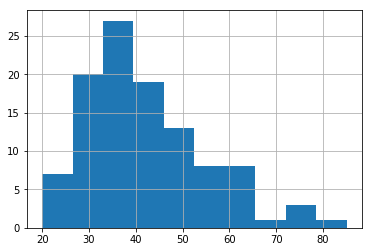

In [35]:
#prelim histogram
df_merged['Age'].hist();

In [36]:
df_merged['Gender'].unique()

array(['M', 'F'], dtype=object)

Dealing with genres: split on comma and fill `None` where necessary.

In [37]:
df_merged.Genres.str.split(',').tolist()

[['Crime', ' Drama'],
 ['Crime', ' Drama', ' Thriller'],
 ['Crime', ' Drama'],
 ['Crime', ' Drama'],
 ['Crime', ' Drama', ' Thriller'],
 ['Adventure', ' Drama', ' Fantasy'],
 ['Adventure', ' Drama', ' Fantasy'],
 ['Adventure', ' Drama', ' Fantasy'],
 ['Crime', ' Drama'],
 ['Biography', ' Drama', ' History'],
 ['Drama'],
 ['Western'],
 ['Drama', ' Romance'],
 ['Drama', ' War'],
 ['Crime', ' Drama', ' Fantasy'],
 ['|'],
 ['|'],
 ['Western'],
 ['Western'],
 ['Drama', ' Western'],
 ['Drama'],
 ['Action', ' Adventure', ' Fantasy'],
 ['Action', ' Adventure', ' Fantasy'],
 ['Action', ' Adventure', ' Fantasy'],
 ['Drama'],
 ['Drama', ' Horror'],
 ['Drama', ' Mystery', ' Thriller'],
 ['Crime', ' Drama', ' Mystery'],
 ['Crime', ' Drama', ' Thriller'],
 ['Drama', ' Family', ' Fantasy'],
 ['Mystery', ' Thriller'],
 ['Mystery', ' Romance', ' Thriller'],
 ['Comedy', ' Drama'],
 ['Animation', ' Adventure', ' Drama'],
 ['Action', ' Sci-Fi'],
 ['Action', ' Sci-Fi'],
 ['Adventure', ' Comedy', ' Sci-Fi']

Turns out our web scraper messed up 6 of our records. We adjust manually. 

In [38]:
df_merged['Genres'].str.startswith('|')

0      False
1      False
2      False
3      False
4      False
       ...  
105    False
106    False
107    False
108    False
109    False
Name: Genres, Length: 110, dtype: object

In [39]:
a = df_merged['Genres'].str.startswith('|')
b = pd.DataFrame(a)
df_merged[b['Genres']== True]

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead,Gender,DOB,Role Type,Age
15,Toy Story 3,2010,103 min,"\nAnimation, Adventure, Comedy",|,8.3,68,"709,283",130.10,Lee Unkrich,Tom Hanks,M,1956.0,R:exuberant,54.0
16,Toy Story,1995,81 min,"\nAnimation, Adventure, Comedy",|,8.3,None,"825,424",None,John Lasseter,Tom Hanks,M,1956.0,R:exuberant,39.0
54,Eternal Sunshine of the Spotless Mind,2004,108 min,"\nDrama, Romance, Sci-F",|,8.3,None,"846,419",0.93,Michel Gondry,Jim Carrey,M,1962.0,R:ubber-lipped comedian,42.0
56,Requiem for a Dream,2000,102 min,\nDrama,|,8.3,None,"718,298",2.83,Darren Aronofsky,Ellen Burstyn,F,1932.0,R:lead,68.0
57,Good Will Hunting,1997,126 min,"\nDrama, Romance",|,8.3,None,"792,481",None,Gus Van Sant,Robin Williams,M,1951.0,R:excentric comedian,46.0
59,Braveheart,1995,178 min,"\nBiography, Drama, History",|,8.3,None,"910,697",None,Mel Gibson,Mel Gibson,M,1951.0,R:lead,44.0


In [40]:
df_merged.loc[15,'Rating'] = 'G'
df_merged.loc[16,'Rating'] = 'G'
df_merged.loc[54,'Rating'] = 'R'
df_merged.loc[56,'Rating'] = 'R'
df_merged.loc[57,'Rating'] = 'R'
df_merged.loc[59,'Rating'] = 'R'

In [41]:
df_merged.loc[15,'Duration (min)'] = 103
df_merged.loc[16,'Duration (min)'] = 81
df_merged.loc[54,'Duration (min)'] = 108
df_merged.loc[56,'Duration (min)'] = 102
df_merged.loc[57,'Duration (min)'] = 126
df_merged.loc[59,'Duration (min)'] = 178

In [42]:
df_merged.loc[15,'Genres'] = 'Animation, Adventure, Comedy'
df_merged.loc[16,'Genres'] = 'Animation, Adventure, Comedy'
df_merged.loc[54,'Genres'] = 'Drama, Romance, Sci-F'
df_merged.loc[56,'Genres'] = 'Drama'
df_merged.loc[57,'Genres'] = 'Drama, Romance'
df_merged.loc[59,'Genres'] = 'Biography, Drama, History'

In [43]:
df_merged[b['Genres']== True]

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead,Gender,DOB,Role Type,Age
15,Toy Story 3,2010,G,103,"Animation, Adventure, Comedy",8.3,68,"709,283",130.10,Lee Unkrich,Tom Hanks,M,1956.0,R:exuberant,54.0
16,Toy Story,1995,G,81,"Animation, Adventure, Comedy",8.3,None,"825,424",None,John Lasseter,Tom Hanks,M,1956.0,R:exuberant,39.0
54,Eternal Sunshine of the Spotless Mind,2004,R,108,"Drama, Romance, Sci-F",8.3,None,"846,419",0.93,Michel Gondry,Jim Carrey,M,1962.0,R:ubber-lipped comedian,42.0
56,Requiem for a Dream,2000,R,102,Drama,8.3,None,"718,298",2.83,Darren Aronofsky,Ellen Burstyn,F,1932.0,R:lead,68.0
57,Good Will Hunting,1997,R,126,"Drama, Romance",8.3,None,"792,481",None,Gus Van Sant,Robin Williams,M,1951.0,R:excentric comedian,46.0
59,Braveheart,1995,R,178,"Biography, Drama, History",8.3,None,"910,697",None,Mel Gibson,Mel Gibson,M,1951.0,R:lead,44.0


All better. 

Now we can continue...

In [44]:
glist = df_merged.Genres.str.split(',').tolist()

In [45]:
#one record had no genre but was not being caputred as a nested list in glist
glist[60] = ['None']
glist

[['Crime', ' Drama'],
 ['Crime', ' Drama', ' Thriller'],
 ['Crime', ' Drama'],
 ['Crime', ' Drama'],
 ['Crime', ' Drama', ' Thriller'],
 ['Adventure', ' Drama', ' Fantasy'],
 ['Adventure', ' Drama', ' Fantasy'],
 ['Adventure', ' Drama', ' Fantasy'],
 ['Crime', ' Drama'],
 ['Biography', ' Drama', ' History'],
 ['Drama'],
 ['Western'],
 ['Drama', ' Romance'],
 ['Drama', ' War'],
 ['Crime', ' Drama', ' Fantasy'],
 ['Animation', ' Adventure', ' Comedy'],
 ['Animation', ' Adventure', ' Comedy'],
 ['Western'],
 ['Western'],
 ['Drama', ' Western'],
 ['Drama'],
 ['Action', ' Adventure', ' Fantasy'],
 ['Action', ' Adventure', ' Fantasy'],
 ['Action', ' Adventure', ' Fantasy'],
 ['Drama'],
 ['Drama', ' Horror'],
 ['Drama', ' Mystery', ' Thriller'],
 ['Crime', ' Drama', ' Mystery'],
 ['Crime', ' Drama', ' Thriller'],
 ['Drama', ' Family', ' Fantasy'],
 ['Mystery', ' Thriller'],
 ['Mystery', ' Romance', ' Thriller'],
 ['Comedy', ' Drama'],
 ['Animation', ' Adventure', ' Drama'],
 ['Action', ' Sci-

In [46]:
maxLen = max(map(len, glist))
max_len = max(len(item) for item in glist)

for item in glist:                # for each item in the list
    while len(item) < max_len:   # while the item length is smaller than 3
        item.append(None)  

In [48]:
#readjusting this special case
glist[60] = [None, None, None]

In [49]:
genres = pd.DataFrame(glist, columns=['Genre 1','Genre 2', 'Genre 3'])

In [50]:
final_movies = pd.concat([df_merged, genres], axis=1, sort=False)
final_movies.head()

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead,Gender,DOB,Role Type,Age,Genre 1,Genre 2,Genre 3
0,The Godfather,1972,R,175,"Crime, Drama",9.2,100,"1,486,705",134.97,Francis Ford Coppola,Marlon Brando,M,1924.0,R:modern male,48.0,Crime,Drama,None
1,On the Waterfront,1954,Not Rated,108,"Crime, Drama, Thriller",8.1,97,"132,069",4.36,Elia Kazan,Marlon Brando,M,1924.0,R:modern male,30.0,Crime,Drama,Thriller
2,The Godfather: Part II,1974,R,202,"Crime, Drama",9.0,90,"1,035,454",57.30,Francis Ford Coppola,Al Pacino,M,1939.0,R:malevolent lead,35.0,Crime,Drama,None
3,Scarface,1983,R,170,"Crime, Drama",8.3,58,"684,464",309.13,Brian De Palma,Al Pacino,M,1939.0,R:malevolent lead,44.0,Crime,Drama,None
4,Heat,1995,R,170,"Crime, Drama, Thriller",8.2,96,"537,312",1.11,Michael Mann,Al Pacino,M,1939.0,R:malevolent lead,56.0,Crime,Drama,Thriller


Finally, let's remove that 'R:' from the Role Types. 

In [55]:
a = final_movies['Role Type'].str.split('R:')
roles = []
for i in range(len(a)):
    roles.append(a[i][-1])

In [57]:
final_movies['Role Type'] = roles

In [58]:
final_movies.head()

,Movie,Year,Rating,Duration (min),Genres,Stars,Metascore,Votes,Gross ($M),Director,Lead,Gender,DOB,Role Type,Age,Genre 1,Genre 2,Genre 3
0,The Godfather,1972,R,175,"Crime, Drama",9.2,100,"1,486,705",134.97,Francis Ford Coppola,Marlon Brando,M,1924.0,modern male,48.0,Crime,Drama,None
1,On the Waterfront,1954,Not Rated,108,"Crime, Drama, Thriller",8.1,97,"132,069",4.36,Elia Kazan,Marlon Brando,M,1924.0,modern male,30.0,Crime,Drama,Thriller
2,The Godfather: Part II,1974,R,202,"Crime, Drama",9.0,90,"1,035,454",57.30,Francis Ford Coppola,Al Pacino,M,1939.0,malevolent lead,35.0,Crime,Drama,None
3,Scarface,1983,R,170,"Crime, Drama",8.3,58,"684,464",309.13,Brian De Palma,Al Pacino,M,1939.0,malevolent lead,44.0,Crime,Drama,None
4,Heat,1995,R,170,"Crime, Drama, Thriller",8.2,96,"537,312",1.11,Michael Mann,Al Pacino,M,1939.0,malevolent lead,56.0,Crime,Drama,Thriller


In [59]:
final_movies.to_excel('final_movies.xlsx')